In [2]:
from numpy import array

import dadi
import demographic_models

data = dadi.Spectrum.from_file('C:\\Users\\vkpankov\\Documents\\BioInf2\\BioInfML\\Project\\YRI_CEU.fs')



In [26]:
from dadi import Numerics, PhiManip, Integration, Spectrum

def OutOfAfrica(params, ns, pts):
    nuAf, nuB, nuEu0, nuEu, nuAs0, nuAs, mAfB, mAfEu, mAfAs, mEuAs, TAf, TB, TEuAs = params
    xx = Numerics.default_grid(pts)

    phi = PhiManip.phi_1D(xx)
    phi = Integration.one_pop(phi, xx, TAf, nu = nuAf)

    phi = PhiManip.phi_1D_to_2D(xx, phi)
    phi = Integration.two_pops(phi, xx, TB, nu1 = nuAf, nu2 = nuB, m12 = mAfB, m21 = mAfB)

    phi = PhiManip.phi_2D_to_3D_split_2(xx, phi)

    nuEu_func = lambda t : nuEu0 * (nuEu/nuEu0) ** (t/TEuAs)
    nuAs_func = lambda t : nuAs0 * (nuAs/nuAs0) ** (t/TEuAs)
    phi = Integration.three_pops(phi, xx, TEuAs, nu1 = nuAf, nu2 = nuEu_func, nu3 = nuAs_func, m12 = mAfEu, m13 = nAfAs, m21 = mAfEu, m23 = mEuAs, m31 = mAfAs, m32 = mEuAs)

    fs = Spectrum.from_phi(phi, (n1, n2, n3), (xx, xx, xx))
    return fs



In [64]:
nuAf, nuB, nuEu0, nuEu, nuAs0, nuAs, mAfB, mAfEu, mAfAs, mEuAs, TAf, TB, TEuAs = 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.4, 0.5
xx = Numerics.default_grid(200)

phi = PhiManip.phi_1D(xx)

phi = Integration.one_pop(phi, xx, 0.5, nu = nuAf)

test_phi = phi

In [18]:
from pydens import Solver, NumpySampler, add_tokens, plot_loss, plot_2d
import numpy as np

add_tokens()
# we've now got functions like sin, cos, D in our namespace. More on that later!

Name `sin` already present in current namespace. Added as sin__
Name `cos` already present in current namespace. Added as cos__
Name `tan` already present in current namespace. Added as tan__
Name `asin` already present in current namespace. Added as asin__
Name `acos` already present in current namespace. Added as acos__
Name `atan` already present in current namespace. Added as atan__
Name `sinh` already present in current namespace. Added as sinh__
Name `cosh` already present in current namespace. Added as cosh__
Name `tanh` already present in current namespace. Added as tanh__
Name `asinh` already present in current namespace. Added as asinh__
Name `acosh` already present in current namespace. Added as acosh__
Name `atanh` already present in current namespace. Added as atanh__
Name `exp` already present in current namespace. Added as exp__
Name `log` already present in current namespace. Added as log__
Name `pow` already present in current namespace. Added as pow__
Name `sqrt` alre

In [3]:
pde = {'n_dims': 2,
       'form': lambda u, x, t: D(u, t) - D(D(u, x), x) - 5 * x * (1 - x),
       'initial_condition': lambda x: x * (1 - x) * 4}

# put it together in model-config
config = {'pde': pde,
          'decay': {'name': 'invtime', 'learning_rate':0.01, 'decay_steps': 100, 'decay_rate': 0.05}}

# uniform sampling scheme
s = NumpySampler('u', dim=2)

model = Solver(config)
model.fit(batch_size=500, sampler=s, n_iters=1200, bar='notebook')




Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
import tensorflow as tf
print(tf.__version__)

1.15.0


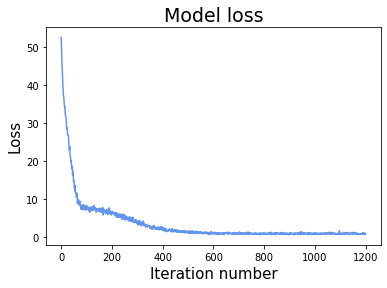

In [7]:
plot_loss(model.loss, color='cornflowerblue')

In [517]:
def integrate(params, ns, pts):
    gamma, theta, T, nuB, nuA = params
    eps = 0.0001
    fix_t = T

    nu_func = lambda t: nuB*np.exp(np.log(nuA/nuB) * t/fix_t)


    #theta/(eps*(1-eps)/nu)
    one_pop_pde = {'n_dims': 2,
        'form': lambda u, x, t: D(u, t) - 0.5 * D(D(x*(1-x)*u*1/(nuB*exp(log(nuA/nuB) * t/fix_t)), x), x) + D(gamma*x*(1-x)*u, x),
        'boundary_condition': lambda t: [theta/(eps*(1-eps)/nu_func(t)),1], 
        'initial_condition': lambda x: nu_func(0)*theta/x}

    # put it together in model-config
    config = {'pde': one_pop_pde,
            'decay': {'name': 'invtime', 'learning_rate':0.01, 'decay_steps': 100, 'decay_rate': 0.05}}

    # uniform sampling scheme
    s = NumpySampler('u', dim=2)

    model = Solver(config)
    model.fit(batch_size=500, sampler=s, n_iters=1000, bar='notebook')
    
    xx = Numerics.default_grid(1000)
    pts = np.array(list(zip(xx, [fix_t]*len(xx))))
    dg = model.solve(pts)
    return dg

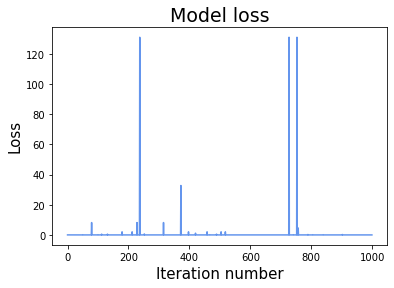

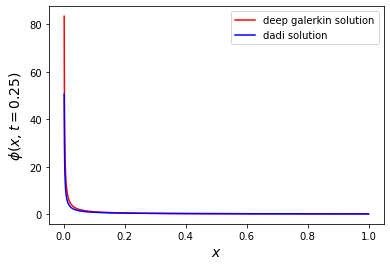

In [501]:

from matplotlib import pyplot as plt

phi = PhiManip.phi_1D(xx, nu = nu_func(0), theta0 = theta, gamma = gamma)
phi_dadi = Integration.one_pop(phi, xx, fix_t, nu = nu_func, gamma = gamma, theta0 = theta, beta=1)


xx = Numerics.default_grid(2000)


plt.plot(xx[190:], dg[190:], 'r', label='deep galerkin solution')
plt.plot(xx[190:], phi_dadi[190:], 'b', label='dadi solution')

plt.xlabel(r'$x$', fontdict={'fontsize': 14})
plt.ylabel(f'$\phi(x, t = {fix_t})$', fontdict={'fontsize': 14})

plt.legend()
plt.show()




In [518]:
import dadi
upper_bound = [100, 100, 10, 3, 3]
lower_bound = [1e-2, 1e-2, 1e-2, 0, 0]
pts_l = [40,50,60]

p0 = [2,0.1,2,1,0.2,0.2]

data = dadi.Spectrum.from_file('example.fs')

popt = dadi.Inference.optimize_log(p0, data, integrate, pts_l, 
                                   lower_bound=lower_bound,
                                   upper_bound=upper_bound,
                                   verbose=len(p0), maxiter=3)

popt

ValueError: too many values to unpack (expected 5)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

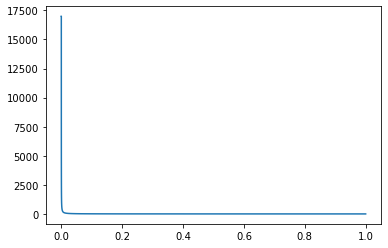

In [303]:
xx = Numerics.default_grid(100)
phi = PhiManip.phi_1D(xx, nu = 1, theta0 = 1.0, gamma = 0)
plt.plot(xx,phi)
#plt.plot(xx,nu*theta/xx)
